In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from keras.utils import plot_model, to_categorical
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K

import warnings
warnings.filterwarnings("ignore")

/home/jun3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load dataset info

In [2]:
path_to_train = './input/train/'
data = pd.read_csv('./input/train.csv')

In [3]:
data.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [4]:
### add more external data
data_ext = pd.read_csv('./HPAv18RBGY_wodpl.csv')

In [5]:
data_ext.head()

,Id,Target
0,10580_1610_C1_1,13 25 0 2 21
1,10580_1610_C1_2,13 25 0 2 21
2,10580_1756_B1_1,13 25 0 2 21
3,10580_1756_B1_2,13 25 0 2 21
4,10580_1758_B1_1,13 25 0 2 21


In [6]:
data2 = data.append(data_ext, ignore_index=True)

In [8]:
len(data2)

105678

In [9]:
len(data)

31072

class names:

0:  "Nucleoplasm",  
1:  "Nuclear membrane",   
2:  "Nucleoli",   
3:  "Nucleoli fibrillar center",   
4:  "Nuclear speckles",
5:  "Nuclear bodies",   
6:  "Endoplasmic reticulum",   
7:  "Golgi apparatus",   
8:  "Peroxisomes",   
9:  "Endosomes",   
10:  "Lysosomes",   
11:  "Intermediate filaments",   
12:  "Actin filaments",   
13:  "Focal adhesion sites",   
14:  "Microtubules",   
15:  "Microtubule ends",   
16:  "Cytokinetic bridge",   
17:  "Mitotic spindle",   
18:  "Microtubule organizing center",   
19:  "Centrosome",   
20:  "Lipid droplets",   
21:  "Plasma membrane",   
22:  "Cell junctions",   
23:  "Mitochondria",   
24:  "Aggresome",   
25:  "Cytosol",   
26:  "Cytoplasmic bodies",   
27:  "Rods & rings"

In [10]:
# Get rods & rings training samples--class 27
rod_lst = []
for i in range(len(data2)):
    if '27' in data2.loc[i,'Target']:
         rod_lst.append(i)

In [11]:
data2.iloc[rod_lst].tail()

,Id,Target
102832,17750_113_G11_2,27
102833,17750_161_G11_1,27
102834,17750_161_G11_2,27
102835,17750_112_G11_1,27
102836,17750_112_G11_2,27


 #### Protein class labels of cytoplasmic bodies, peroxisomes, endosomes, lysosomes, microtubule ends, and rods & rings are rare.  I over sampling these data [12-67]

In [12]:
data2 = data2.append(data2.iloc[rod_lst],ignore_index=True) # add 5X more rare class "Rods & rings" data

In [13]:
data2 = data2.append(data2.iloc[rod_lst],ignore_index=True)

In [14]:
data2 = data2.append(data2.iloc[rod_lst],ignore_index=True)

In [15]:
data2 = data2.append(data2.iloc[rod_lst],ignore_index=True)

In [16]:
data2 = data2.append(data2.iloc[rod_lst],ignore_index=True)

In [17]:
len(data2)

106313

In [18]:
mt_end_lst = []

for i in range(len(data2)):
    if '15' in data2.loc[i,'Target']:
         mt_end_lst.append(i)

In [19]:
data2 = data2.append(data2.iloc[mt_end_lst],ignore_index=True)  # add 6X more "Microtubule ends" data 

In [20]:
data2 = data2.append(data2.iloc[mt_end_lst],ignore_index=True)

In [21]:
data2 = data2.append(data2.iloc[mt_end_lst],ignore_index=True)

In [22]:
data2 = data2.append(data2.iloc[mt_end_lst],ignore_index=True)

In [23]:
data2 = data2.append(data2.iloc[mt_end_lst],ignore_index=True)

In [24]:
data2 = data2.append(data2.iloc[mt_end_lst],ignore_index=True)

In [25]:
len(data2)

106691

In [26]:
lyso_lst = []
for i in range(len(data2)):
    if '10' in data2.loc[i,'Target']:
         lyso_lst.append(i)

In [27]:
data2 = data2.append(data2.iloc[lyso_lst],ignore_index=True)  # add 4X more "Lysosomes" data 

In [28]:
data2 = data2.append(data2.iloc[lyso_lst],ignore_index=True)

In [29]:
data2 = data2.append(data2.iloc[lyso_lst],ignore_index=True)

In [30]:
data2 = data2.append(data2.iloc[lyso_lst],ignore_index=True)

In [31]:
len(data2)

107419

In [32]:
endo_lst2 = []

for i in range(len(data2)):
    if ' 9' in data2.loc[i,'Target']:
         endo_lst2.append(i)

In [33]:
len(data2.iloc[endo_lst2])

235

In [34]:
data2 = data2.append(data2.iloc[endo_lst2],ignore_index=True)  # add 3X more "Endosomes" data 

In [35]:
data2 = data2.append(data2.iloc[endo_lst2],ignore_index=True)

In [36]:
data2 = data2.append(data2.iloc[endo_lst2],ignore_index=True)

In [37]:
len(data2)

108124

In [38]:
pero_lst = []
for i in range(len(data2)):
    if ' 8' in data2.loc[i,'Target']:
         pero_lst.append(i)

In [39]:
len(pero_lst)

52

In [40]:
data2 = data2.append(data2.iloc[pero_lst],ignore_index=True) # add 6X more "Peroxisomes" data 

In [41]:
data2 = data2.append(data2.iloc[pero_lst],ignore_index=True)

In [42]:
data2 = data2.append(data2.iloc[pero_lst],ignore_index=True)

In [43]:
data2 = data2.append(data2.iloc[pero_lst],ignore_index=True)

In [44]:
data2 = data2.append(data2.iloc[pero_lst],ignore_index=True)

In [45]:
data2 = data2.append(data2.iloc[pero_lst],ignore_index=True)

In [46]:
len(data2)

108436

In [47]:
lip_lst = []
for i in range(len(data2)):
    if '20' in data2.loc[i,'Target']:
         lip_lst.append(i)

In [48]:
data2 = data2.append(data2.iloc[lip_lst],ignore_index=True) # add 3X more "Lipid droplets" data 

In [49]:
data2 = data2.append(data2.iloc[lip_lst],ignore_index=True)

In [50]:
data2 = data2.append(data2.iloc[lip_lst],ignore_index=True)

In [51]:
len(data2)

109750

In [52]:
len(lip_lst)

438

In [53]:
mit_lst = []
for i in range(len(data2)):
    if '17' in data2.loc[i,'Target']:
         mit_lst.append(i)

In [54]:
len(mit_lst)

446

In [55]:
data2 = data2.append(data2.iloc[mit_lst],ignore_index=True) # add 2X more "Mitotic spindle" data 

In [56]:
data2 = data2.append(data2.iloc[mit_lst],ignore_index=True)

In [57]:
len(data2)

110642

In [58]:
aggr_lst = []
for i in range(len(data2)):
    if '24' in data2.loc[i,'Target']:
         aggr_lst.append(i)

In [59]:
len(aggr_lst)

428

In [60]:
data2 = data2.append(data2.iloc[aggr_lst],ignore_index=True) # add 2X more "Aggresome" data 

In [61]:
data2 = data2.append(data2.iloc[aggr_lst],ignore_index=True)

In [62]:
len(data2)

111498

In [63]:
cytobody_lst = []
for i in range(len(data2)):
    if '26' in data2.loc[i,'Target']:
         cytobody_lst.append(i)

In [64]:
len(cytobody_lst)

706

In [65]:
data2 = data2.append(data2.iloc[cytobody_lst],ignore_index=True) # add 1X more "Cytoplasmic bodies" data

In [66]:
data2 = data2.append(data2.iloc[cytobody_lst],ignore_index=True) 

In [67]:
len(data2)

112910

In [68]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [69]:
train_dataset_info = []
for name, labels in zip(data2['Id'], data2['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [70]:
len(train_dataset_info)

112910

In [71]:
train_dataset_info[0:2]

array([{'path': './input/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])},
       {'path': './input/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', 'labels': array([7, 1, 2, 0])}],
      dtype=object)

In [72]:
### The function below converts a list of labels into 28 element arrays 
### (corresponding to 28 classes of subcellular localizations). 

def convert_to_categorical(label, num_classes=28):
    cat_label = []
    for i in label:
        
        tmp = to_categorical(i, num_classes=num_classes).reshape(1, -1)
        cat_label.append(tmp)

    cat_label = np.array(cat_label)
    return np.sum(cat_label, axis=0, keepdims=True)[0][0]  # return final multi-class label

In [73]:
for i in train_dataset_info:
    i['labels'] = convert_to_categorical(i['labels'])

In [74]:
train_dataset_info[0]['labels']
# converted properly

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [75]:
IDs = []
labels = {}
for i, item in enumerate(train_dataset_info):  
    id = item['path']
    IDs.append(id)
    labels[id] = item['labels']    

In [76]:
label_lst = []
for i, item in enumerate(train_dataset_info):  
    label = item['labels']
    label_lst.append(label)

In [77]:
label_lst[31071]

array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [78]:
len(IDs)

112910

In [79]:
import random
random.seed(42)
random.shuffle(IDs)

In [80]:
IDs[0:2]

['./input/train/42776_579_E5_3', './input/train/20981_284_E3_1']

In [81]:
partition = {'train': IDs[0:89408], 'validation': IDs[89408:]}

In [82]:
partition['validation'][1]

'./input/train/29349_340_F3_5'

### Create Datagenerator

In [83]:
class DataGenerator(keras.utils.Sequence):
    ### Generates data for Keras
    def __init__(self, list_IDs, list_labels, batch_size=16, shape=(512,512,4), random_crop_size=(255,255), 
                 n_classes=28, shuffle=True, crop=True):
        # Initialization
        self.shape = shape
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.list_labels = list_labels
        self.n_classes = n_classes       
        self.shuffle = shuffle
        self.crop = crop
        self.random_crop_size = random_crop_size
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes) 

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, batch_num):
        'Generate one batch of data'
        # Generate indexes of the batch
        
        batch_indexes = self.indexes[batch_num*self.batch_size:(batch_num+1)*self.batch_size]

        # Find list of IDs
        
        list_IDs_temp = [self.list_IDs[k] for k in batch_indexes]
        
        # Generate data
        X, y = self.data_gen(list_IDs_temp)
        return X, y

    def data_gen(self, IDs):
        
        batch_labels = np.zeros((len(IDs), self.n_classes))
        batch_images = np.empty((len(IDs), self.random_crop_size[0], self.random_crop_size[1], self.shape[2])) 
        
        for i, ID in enumerate(IDs):            
            image = DataGenerator.load_image(ID)   
            image = DataGenerator.random_crop(image, self.random_crop_size)
            image = DataGenerator.augment(image)
            
            batch_images[i] = image
            batch_labels[i]= self.list_labels[ID]
        
        return batch_images, batch_labels

    def load_image(ID):
        image_red_ch = skimage.io.imread(ID+'_red.png')/255 # label microtubules
        image_yellow_ch = skimage.io.imread(ID+'_yellow.png')/255 # label endoplasmatic reticulum
        image_green_ch = skimage.io.imread(ID+'_green.png')/255 # target protein structure
        image_blue_ch = skimage.io.imread(ID+'_blue.png')/255 # label nucleus
        image = np.stack((image_red_ch, image_yellow_ch, image_green_ch, image_blue_ch), -1)
        #image = resize(image, (shape[0], shape[1]), mode='reflect')
        return image       
    
    def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
        
        height, width = img.shape[0], img.shape[1]
        dy, dx = random_crop_size
        x = np.random.randint(0, width - dx + 1)
        y = np.random.randint(0, height - dy + 1)
        return img[y:(y+dy), x:(x+dx), :]
    
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug

###  Show data

### Create model

In [84]:
from keras.layers import BatchNormalization

def create_model(input_shape, n_out):
    
    InRes_model = InceptionResNetV2(
        include_top=False, 
        weights= None, 
        input_shape=input_shape)
    
    model = Sequential()
    model.add(InRes_model)
    model.add(BatchNormalization(axis = 3))
    model.add(Flatten())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(n_out))
    model.add(Activation('sigmoid'))
    return model

In [85]:
keras.backend.clear_session()

model = create_model(
    input_shape=(255,255,4), 
    n_out=28)
model = load_model('./InceptionResNetV2_jun2_bina255j-Copy1.hdf5') 
# The weights are from the same model I trained previously. I had 16GB RAM. The model fitting oftens stopped due out of resource.  
# I did duplicated and saved some weights for "load_model".  

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(5e-05),
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 6, 6, 1536)        54337024  
_________________________________________________________________
batch_normalization_204 (Bat (None, 6, 6, 1536)        6144      
_________________________________________________________________
flatten_1 (Flatten)          (None, 55296)             0         
_________________________________________________________________
activation_204 (Activation)  (None, 55296)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 55296)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               28312064  
_________________________________________________________________
activation_205 (Activation)  (None, 512)               0         
__________

In [86]:
params = {'shape': (512, 512, 4),
          'batch_size': 16,
          'random_crop_size': (255,255),
          'n_classes': 28}

epochs = 12
checkpointer = ModelCheckpoint(filepath='./InceptionResNetV2_jun2_bina255k.h5', 
    verbose=2, 
    save_best_only=True)


# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels,  **params)

# Train model on dataset
history = model.fit_generator(
    training_generator,
    validation_data=validation_generator,
    epochs=epochs, 
    verbose=1,
    callbacks=[checkpointer], use_multiprocessing=True)

Epoch 1/12
5588/5588 [==============================] - 2250s 403ms/step - loss: 0.0967 - acc: 0.9676 - val_loss: 0.0947 - val_acc: 0.9680

Epoch 00001: val_loss improved from inf to 0.09467, saving model to ./InceptionResNetV2_jun2_bina255k.h5
Epoch 2/12
5588/5588 [==============================] - 2182s 390ms/step - loss: 0.0953 - acc: 0.9679 - val_loss: 0.0954 - val_acc: 0.9670

Epoch 00002: val_loss did not improve from 0.09467
Epoch 3/12
5588/5588 [==============================] - 2233s 400ms/step - loss: 0.0944 - acc: 0.9681 - val_loss: 0.0947 - val_acc: 0.9680

Epoch 00003: val_loss did not improve from 0.09467
Epoch 4/12
5588/5588 [==============================] - 2328s 417ms/step - loss: 0.0937 - acc: 0.9683 - val_loss: 0.0940 - val_acc: 0.9684

Epoch 00004: val_loss improved from 0.09467 to 0.09402, saving model to ./InceptionResNetV2_jun2_bina255k.h5
Epoch 5/12
5588/5588 [==============================] - 2366s 423ms/step - loss: 0.0927 - acc: 0.9686 - val_loss: 0.0916 - v

### Train model

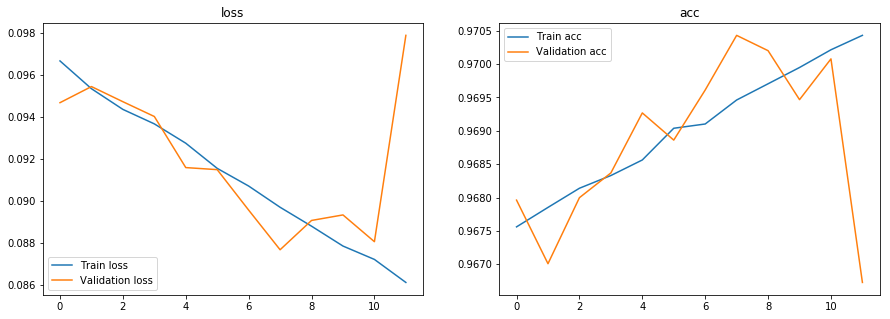

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
ax[0].legend()
ax[1].legend()

### Create submit

In [88]:
model = load_model('./InceptionResNetV2_jun2_bina255k.h5')

In [89]:
submit = pd.read_csv('./input/sample_submission.csv')

In [90]:
len(submit)

11702

In [91]:
submit['path_Id'] = './input/test/' + submit['Id']  

In [92]:
submit['path_Id'].head()

0    ./input/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0
1    ./input/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0
2    ./input/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0
3    ./input/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0
4    ./input/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0
Name: path_Id, dtype: object

In [93]:
submit.head()

,Id,Predicted,path_Id
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0,./input/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0,./input/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0,./input/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0,./input/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0,./input/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0


In [94]:
predicted35 = []
predicted40 = []
predicted45 = []
predicted50 = []
predicted25 = []
predicted30 = []

score_predict_IncRes255k = []

for i in range(len(submit['path_Id'])):
    ID = submit.loc[i,'path_Id']

    image = DataGenerator.load_image(ID)
    image1 = DataGenerator.random_crop(image, (255, 255))
    image2 = DataGenerator.random_crop(image, (255, 255))
    image3 = DataGenerator.random_crop(image, (255, 255))
    image4 = DataGenerator.random_crop(image, (255, 255))
    image5 = DataGenerator.random_crop(image, (255, 255))
    image6 = DataGenerator.random_crop(image, (255, 255))
    image7 = DataGenerator.random_crop(image, (255, 255))
    image8 = DataGenerator.random_crop(image, (255, 255))
    score_predict_arr = np.concatenate(([model.predict(image1[np.newaxis])[0]],
                                       [model.predict(image2[np.newaxis])[0]],
                                       [model.predict(image3[np.newaxis])[0]],
                                       [model.predict(image4[np.newaxis])[0]],
                                       [model.predict(image5[np.newaxis])[0]],
                                       [model.predict(image6[np.newaxis])[0]],
                                       [model.predict(image7[np.newaxis])[0]],
                                       [model.predict(image8[np.newaxis])[0]]), axis=0)
    score_predict = np.max(score_predict_arr, axis=0)
    label_predict35 = np.arange(28)[score_predict>=0.35]
    label_predict40 = np.arange(28)[score_predict>=0.40]
    label_predict45 = np.arange(28)[score_predict>=0.45]
    label_predict50 = np.arange(28)[score_predict>=0.50]
    label_predict25 = np.arange(28)[score_predict>=0.25]
    label_predict30 = np.arange(28)[score_predict>=0.30]
    
    str_predict_label35 = ' '.join(str(l) for l in label_predict35)
    str_predict_label40 = ' '.join(str(l) for l in label_predict40)
    str_predict_label45 = ' '.join(str(l) for l in label_predict45)
    str_predict_label50 = ' '.join(str(l) for l in label_predict50)
    str_predict_label25 = ' '.join(str(l) for l in label_predict25)
    str_predict_label30 = ' '.join(str(l) for l in label_predict30)
    
    
    predicted35.append(str_predict_label35)
    predicted40.append(str_predict_label40)
    predicted45.append(str_predict_label45)
    predicted50.append(str_predict_label50)
    predicted25.append(str_predict_label25)
    predicted30.append(str_predict_label30)
    
    score_predict_IncRes255k.append(score_predict)
    
# I used different threshold for the prediction.  The best threshold for "post competition submission" was "score_predict>=0.50"

In [95]:
submit35 = submit.copy()
submit35['Predicted'] = predicted35

In [96]:
submit40 = submit.copy()
submit40['Predicted'] = predicted40

In [97]:
submit45 = submit.copy()
submit45['Predicted'] = predicted45

In [98]:
submit50 = submit.copy()
submit50['Predicted'] = predicted50

In [99]:
submit25 = submit.copy()
submit25['Predicted'] = predicted25

In [100]:
submit30 = submit.copy()
submit30['Predicted'] = predicted30

In [101]:
submit35.drop(labels='path_Id', axis=1, inplace=True)

In [102]:
submit40.drop(labels='path_Id', axis=1, inplace=True)

In [103]:
submit45.drop(labels='path_Id', axis=1, inplace=True)

In [104]:
submit50.drop(labels='path_Id', axis=1, inplace=True)

In [105]:
submit25.drop(labels='path_Id', axis=1, inplace=True)

In [106]:
submit30.drop(labels='path_Id', axis=1, inplace=True)

In [110]:
submit50.tail(2)

,Id,Predicted
11700,fff03816-bad5-11e8-b2b9-ac1f6b6435d0,0 1
11701,fffe6f9c-bacd-11e8-b2b8-ac1f6b6435d0,0 25


In [113]:
submit35.to_csv('submission35k.csv', index=False)

In [114]:
submit40.to_csv('submission40k.csv', index=False)

In [115]:
submit45.to_csv('submission45k.csv', index=False)

In [116]:
submit50.to_csv('submission50k.csv', index=False)

In [119]:
submit25.to_csv('submission25k.csv', index=False)

In [120]:
submit30.to_csv('submission30k.csv', index=False)